In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.data.metrics import bleu_score
from torchtext.vocab import build_vocab_from_iterator

import random
import numpy as np

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [2]:
# 设置随机种子
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# 获取分词器
tokenizer_de = get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')

In [4]:
# 划分训练集、验证集和测试集
train_data, valid_data, test_data = Multi30k(root='NLP/dataset/Multi30k',
                                            split=('train', 'valid', 'test'), language_pair=('de', 'en'))

In [5]:
# 生成词表的迭代函数
def yield_tokens(dataset, language):
    for de, en in dataset:
        if language == 'de':
            yield [token.lower() for token in tokenizer_de(de)]
        elif language == 'en':
            yield [token.lower() for token in tokenizer_en(en)]
        else:
            raise KeyError

In [ ]:
# 构建词表
special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']
UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

vocab_de = build_vocab_from_iterator(yield_tokens(train_data,'de'), min_freq=2, 
                                    specials=special_tokens, special_first=True)

vocab_en = build_vocab_from_iterator(yield_tokens(train_data,'en'), min_freq=2, 
                                    specials=special_tokens, special_first=True)

vocab_de.set_default_index(UNK_IDX)
vocab_en.set_default_index(UNK_IDX)

In [7]:
# 将句子进行分词，to_id，转为tensor
def transform_text(sentence, language):
    if language == 'de':
        # 分词
        sentence = [token.lower() for token in tokenizer_de(sentence)]
        # 转换为id
        sentence = [vocab_de[i] for i in sentence]
    elif language == 'en':
        sentence = [token.lower() for token in tokenizer_en(sentence)]
        sentence = [vocab_en[i] for i in sentence]
    else:
        raise KeyError
    # 转为tensor
    sentence = torch.cat((torch.tensor([SOS_IDX]), torch.tensor(sentence), torch.tensor([EOS_IDX])))
    return sentence

In [8]:
def collate_fn(data):
    batch_de, batch_en = [], []
    for de, en in data:
        de = transform_text(de, 'de')
        en = transform_text(en, 'en')
        batch_de.append(de)
        batch_en.append(en)
    batch_de = pad_sequence(batch_de, padding_value=PAD_IDX, batch_first=True)
    batch_en = pad_sequence(batch_en, padding_value=PAD_IDX, batch_first=True)

    return batch_de, batch_en

In [9]:
# 获取dataloader
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=128, shuffle=True, drop_last=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True, drop_last=True, collate_fn=collate_fn)

In [10]:
# 多头注意力层
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.hid_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q = [batch_size, n_heads, seq_len, head_dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        # energy = [batch_size, n_heads, seq_len, seq_len]
        energy = torch.matmul(Q, K.permute(0,1,3,2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        # x = [batch_size, n_heads, seq_len, head_dim]
        x = torch.matmul(self.dropout(attention), V)
        # x = [batch_size, seq_len, n_heads, head_dim]
        x = x.permute(0,2,1,3).contiguous()
        # x = [batch_size, seq_len, hid_dim]
        x = x.view(batch_size, -1, self.hid_dim)

        x = self.fc_o(x)

        return x, attention


In [11]:
# FFN层
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        return x


In [12]:
# EncoderLayer层
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src


In [13]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=100):
        super().__init__()
        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([
            EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
            for _ in range(n_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)


    def forward(self, src, src_mask):
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        src = self.tok_embedding(src) * self.scale + self.pos_embedding(pos)

        src = self.dropout(src)

        for layer in self.layers:
            src = layer(src, src_mask)
        
        return src

In [14]:
# DecoderLayer层
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.cross_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.cross_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, src_mask, trg_mask):
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        _trg, attention = self.cross_attention(trg, enc_src, enc_src, src_mask)
        trg = self.cross_attn_layer_norm(trg + self.dropout(_trg))

        _trg = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        return trg, attention

In [15]:
# Decoder层
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([
            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
            for _ in range(n_layers)
        ])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, src_mask, trg_mask):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        trg = self.dropout(self.tok_embedding(trg) * self.scale + self.pos_embedding(pos))

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, src_mask, trg_mask)
        
        output = self.fc_out(trg)

        return output, attention

In [16]:
# Transformer网络
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, device, src_pad_idx, trg_pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
    
    def make_src_mask(self, src):
        # src_mask = [batch_size, 1, 1, seq_len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_trg_mask(self, trg):
        # 对pad进行mask
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        seq_len = trg.shape[1]
        # 对trg端后面的word进行mask
        trg_sub_mask = torch.tril(torch.ones((seq_len, seq_len),device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)

        output, attention = self.decoder(trg, enc_src, src_mask, trg_mask)

        return output, attention

In [17]:
input_dim = len(vocab_de)
output_dim = len(vocab_en)
hid_dim = 256 # 512
enc_layers = 3 # 6
dec_layers = 3 # 6
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512 # 2048
dec_pf_dim = 512 # 2048
enc_dropout = 0.1
dec_dropout = 0.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, device)
decoder = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, dec_dropout, device)
model = Transformer(encoder, decoder, device, PAD_IDX, PAD_IDX).to(device)


In [18]:
# 统计可训练的参数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [19]:
# 对网络进行初始化
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

In [20]:
# 设置优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [21]:
# 训练
def train(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for src, trg in dataloader:
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()
        output, attention = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        # output = [batch_size * seq_len, output_dim]
        output = output.contiguous().view(-1, output_dim)
        # trg = [batch_size * seq_len]
        trg = trg[:, 1:].contiguous().view(-1)
        loss = criterion(output, trg)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(list(dataloader))


In [22]:
# 评估
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(device)
            trg = trg.to(device)

            output, attention = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(list(dataloader))

In [23]:
# 计算每个epoch的训练时长
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
epochs = 10
clip = 1

best_valid_loss = float('inf')
# 训练
for epoch in range(epochs):
    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 15s
	Train Loss: 4.236 | Train PPL:  69.122
	 Val. Loss: 3.125 |  Val. PPL:  22.757
Epoch: 02 | Time: 0m 15s
	Train Loss: 2.837 | Train PPL:  17.071
	 Val. Loss: 2.393 |  Val. PPL:  10.949
Epoch: 03 | Time: 0m 15s
	Train Loss: 2.217 | Train PPL:   9.177
	 Val. Loss: 2.014 |  Val. PPL:   7.490
Epoch: 04 | Time: 0m 15s
	Train Loss: 1.842 | Train PPL:   6.308
	 Val. Loss: 1.844 |  Val. PPL:   6.321
Epoch: 05 | Time: 0m 14s
	Train Loss: 1.588 | Train PPL:   4.892
	 Val. Loss: 1.746 |  Val. PPL:   5.731
Epoch: 06 | Time: 0m 15s
	Train Loss: 1.395 | Train PPL:   4.035
	 Val. Loss: 1.682 |  Val. PPL:   5.375
Epoch: 07 | Time: 0m 15s
	Train Loss: 1.241 | Train PPL:   3.458
	 Val. Loss: 1.648 |  Val. PPL:   5.194
Epoch: 08 | Time: 0m 14s
	Train Loss: 1.114 | Train PPL:   3.048
	 Val. Loss: 1.694 |  Val. PPL:   5.439
Epoch: 09 | Time: 0m 15s
	Train Loss: 1.006 | Train PPL:   2.734
	 Val. Loss: 1.688 |  Val. PPL:   5.409
Epoch: 10 | Time: 0m 14s
	Train Loss: 0.911 | Train PPL

In [25]:
# 评估
test_loss = evaluate(model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.790 | Test PPL:   5.988 |


In [26]:
# 翻译句子
def translate_sentence(sentence, max_length=100):
    model.eval()
    src = transform_text(sentence, 'de').unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src)

    with torch.no_grad():
        enc_src = model.encoder(src, src_mask)

    trg_indices = [SOS_IDX]
    for i in range(max_length):
        trg = torch.LongTensor(trg_indices).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg)
        with torch.no_grad():
            output, attention = model.decoder(trg, enc_src, src_mask, trg_mask)
        pred_token = output.argmax(dim=-1)[:,-1].item()
        trg_indices.append(pred_token)
        if pred_token == EOS_IDX:
            break
    trg_tokens = [vocab_en.get_itos()[i] for i in trg_indices]
    return trg_tokens[1:], attention


In [27]:
# 可视化 attention
def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):
    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15,25))
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        # 获取第 i 个词对源词的注意力分数
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='binary')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


src:  ['Eine', 'Frau', 'verwendet', 'eine', 'Bohrmaschine', 'während', 'ein', 'Mann', 'sie', 'fotografiert', '.']
pred:  ['a', 'woman', 'uses', 'an', 'drill', 'to', 'take', 'a', 'picture', 'of', 'a', 'man', '.', '<eos>']
reference:  ['A', 'woman', 'uses', 'a', 'drill', 'while', 'another', 'man', 'takes', 'her', 'picture', '.']


/tmp/ipykernel_17976/2445466073.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],rotation=45)
/tmp/ipykernel_17976/2445466073.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


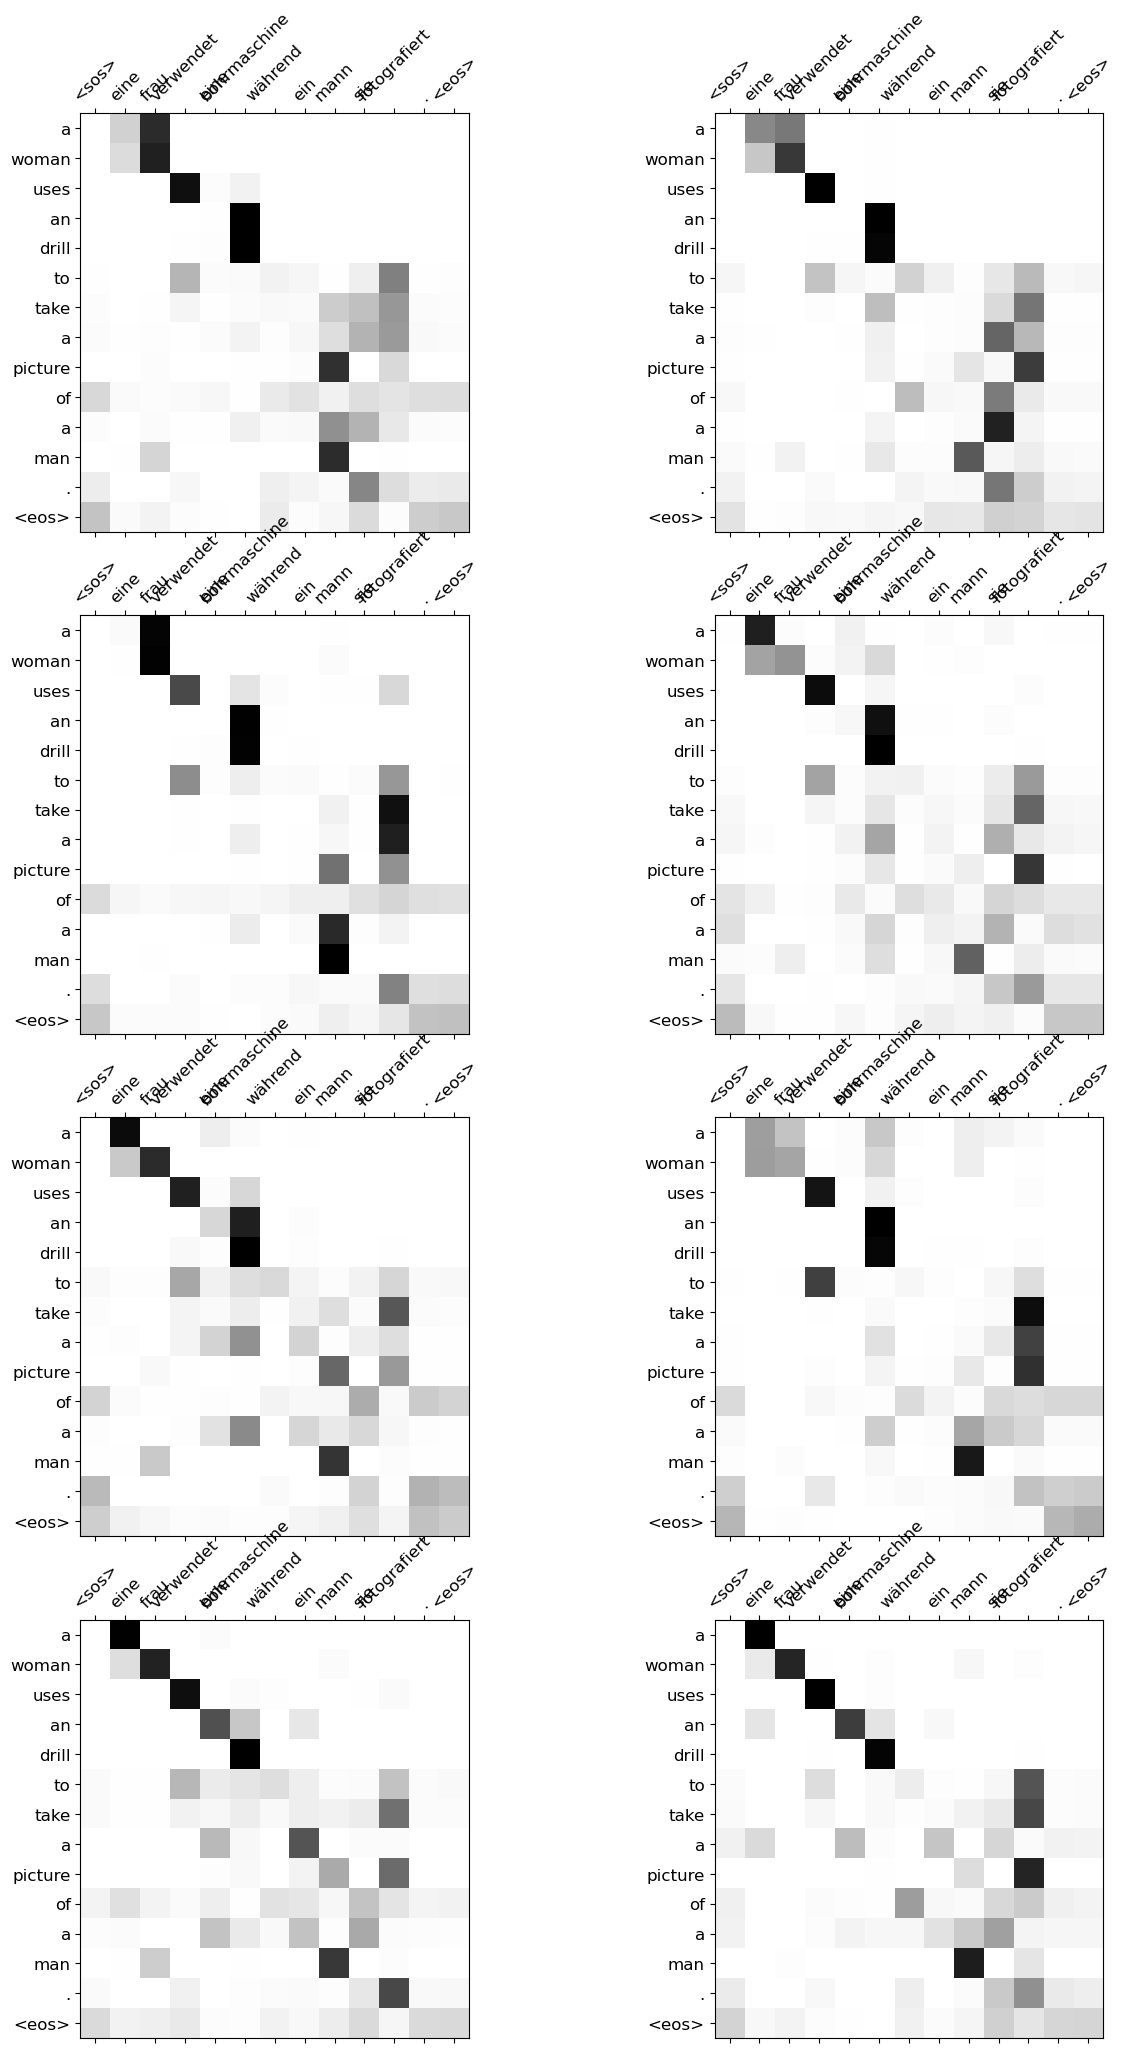

In [28]:
idx = 6
tmp = list(test_data)
de = tmp[idx][0]
en = tmp[idx][1]

translation, attention = translate_sentence(de)

de = tokenizer_de(de)
en = tokenizer_en(en)
print('src: ',de)
print('pred: ', translation)
print('reference: ', en)
display_attention(de, translation, attention)

In [29]:
# 计算 BLEU 分数
predictions = []
references = []
for de, en in test_data:
    en = en.lower()
    en = tokenizer_en(en)
    pred = translate_sentence(de)[0][:-1]
    references.append([en])
    predictions.append(pred)

bleu_score(predictions, references)

0.35144642291584016